In [1]:
pip install pycryptodome


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.2 MB/s eta 0:00:00


In [2]:
pip install pycryptodomex


In [3]:
import os
print("Current Working Directory:", os.getcwd())
print("Files in Directory:", os.listdir())


Current Working Directory: /content
Files in Directory: ['.config', 'sample_data']


In [4]:
import base64
import os
import time
import json
import textwrap
from datetime import datetime, timedelta

from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

# Key Management Class with Key Rotation and Expiry
class KeyManager:
    def __init__(self):
        self.keys = {}  # Store keys with expiration date

    def generate_new_key(self, user_id):
        new_key = os.urandom(32)  # 256-bit key
        expiry_date = datetime.now() + timedelta(days=30)
        self.keys[user_id] = {'key': new_key, 'expiry': expiry_date}
        return new_key

    def check_key_expiry(self, user_id):
        key_info = self.keys.get(user_id)
        if not key_info:
            return False
        return datetime.now() > key_info['expiry']

    def rotate_key(self, user_id):
        if self.check_key_expiry(user_id):
            return self.generate_new_key(user_id)
        return self.keys[user_id]['key']

# ECIES Encryption
def encrypt_ecies(message, recipient_public_key):
    ephemeral_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    ephemeral_public_key = ephemeral_private_key.public_key()

    shared_secret = ephemeral_private_key.exchange(ec.ECDH(), recipient_public_key)

    aes_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b"ecdh-encryption",
        backend=default_backend()
    ).derive(shared_secret)

    iv = os.urandom(12)
    cipher = Cipher(algorithms.AES(aes_key), modes.GCM(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(message.encode()) + encryptor.finalize()

    return {
        "ephemeral_public_key": base64.b64encode(
            ephemeral_public_key.public_bytes(
                encoding=serialization.Encoding.PEM,
                format=serialization.PublicFormat.SubjectPublicKeyInfo
            )
        ).decode(),
        "iv": base64.b64encode(iv).decode(),
        "ciphertext": base64.b64encode(ciphertext).decode(),
        "tag": base64.b64encode(encryptor.tag).decode()
    }

def decrypt_ecies(encrypted_data, recipient_private_key):
    ephemeral_public_key = serialization.load_pem_public_key(
        base64.b64decode(encrypted_data["ephemeral_public_key"]),
        backend=default_backend()
    )
    iv = base64.b64decode(encrypted_data["iv"])
    ciphertext = base64.b64decode(encrypted_data["ciphertext"])
    tag = base64.b64decode(encrypted_data["tag"])

    shared_secret = recipient_private_key.exchange(ec.ECDH(), ephemeral_public_key)

    aes_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b"ecdh-encryption",
        backend=default_backend()
    ).derive(shared_secret)

    cipher = Cipher(algorithms.AES(aes_key), modes.GCM(iv, tag), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_message = decryptor.update(ciphertext) + decryptor.finalize()

    return decrypted_message.decode()

# File Shredding
def shred_file(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r+b') as f:
            length = os.path.getsize(file_path)
            f.write(os.urandom(length))
        os.remove(file_path)
        print(f"[+] File '{file_path}' securely shredded.")
    else:
        print(f"[-] File '{file_path}' not found, skipping shredding.")

# Main Encryption System
class EncryptionSystem:
    def __init__(self, shred_original=True):
        self.key_manager = KeyManager()
        self.shred_original = shred_original

    def encrypt_file(self, file_path, recipient_public_key):
        try:
            if not os.path.exists(file_path):
                print(f"[!] File '{file_path}' not found. Creating with meaningful content...")
                with open(file_path, 'w') as file:
                    file.write(textwrap.dedent("""\
                        This is a secure document containing sensitive information.

                        User ID: 548932
                        Access Level: Administrator
                        Timestamp: {}

                        Confidential Message:
                        The vault access code is 7391-ABCD. Do not share this with anyone.
                        """.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))))

            with open(file_path, 'r') as file:
                message = file.read()

            encrypted_data = encrypt_ecies(message, recipient_public_key)

            with open('cipher.txt', 'w') as cipher_file:
                json.dump(encrypted_data, cipher_file)

            if self.shred_original:
                shred_file(file_path)

            print("[+] Encryption completed. Encrypted data saved to 'cipher.txt'.")
        except Exception as e:
            print(f"[!] Error during file encryption: {e}")
            raise

    def decrypt_file(self, recipient_private_key):
        try:
            with open('cipher.txt', 'r') as cipher_file:
                encrypted_data = json.load(cipher_file)

            decrypted_message = decrypt_ecies(encrypted_data, recipient_private_key)

            with open('decrypted.txt', 'w') as decrypted_file:
                decrypted_file.write(decrypted_message)

            print("[+] Decryption completed. Decrypted message saved to 'decrypted.txt'.")
        except Exception as e:
            print(f"[!] Error during file decryption: {e}")
            raise

# Main Test Function
def main():
    start_time = time.time()

    sender_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    receiver_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    sender_public_key = sender_private_key.public_key()
    receiver_public_key = receiver_private_key.public_key()

    encryption_system = EncryptionSystem(shred_original=False)
    encryption_system.key_manager.generate_new_key("sender")
    encryption_system.key_manager.generate_new_key("receiver")

    encryption_system.encrypt_file("example.txt", receiver_public_key)
    encryption_system.decrypt_file(receiver_private_key)

    end_time = time.time()
    print(f"[✓] Total time taken: {end_time - start_time:.4f} seconds.")

if __name__ == "__main__":
    main()


[!] File 'example.txt' not found. Creating with meaningful content...
[+] Encryption completed. Encrypted data saved to 'cipher.txt'.
[+] Decryption completed. Decrypted message saved to 'decrypted.txt'.
[✓] Total time taken: 0.0192 seconds.


<ipython-input-5-4af771204e12>:46: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


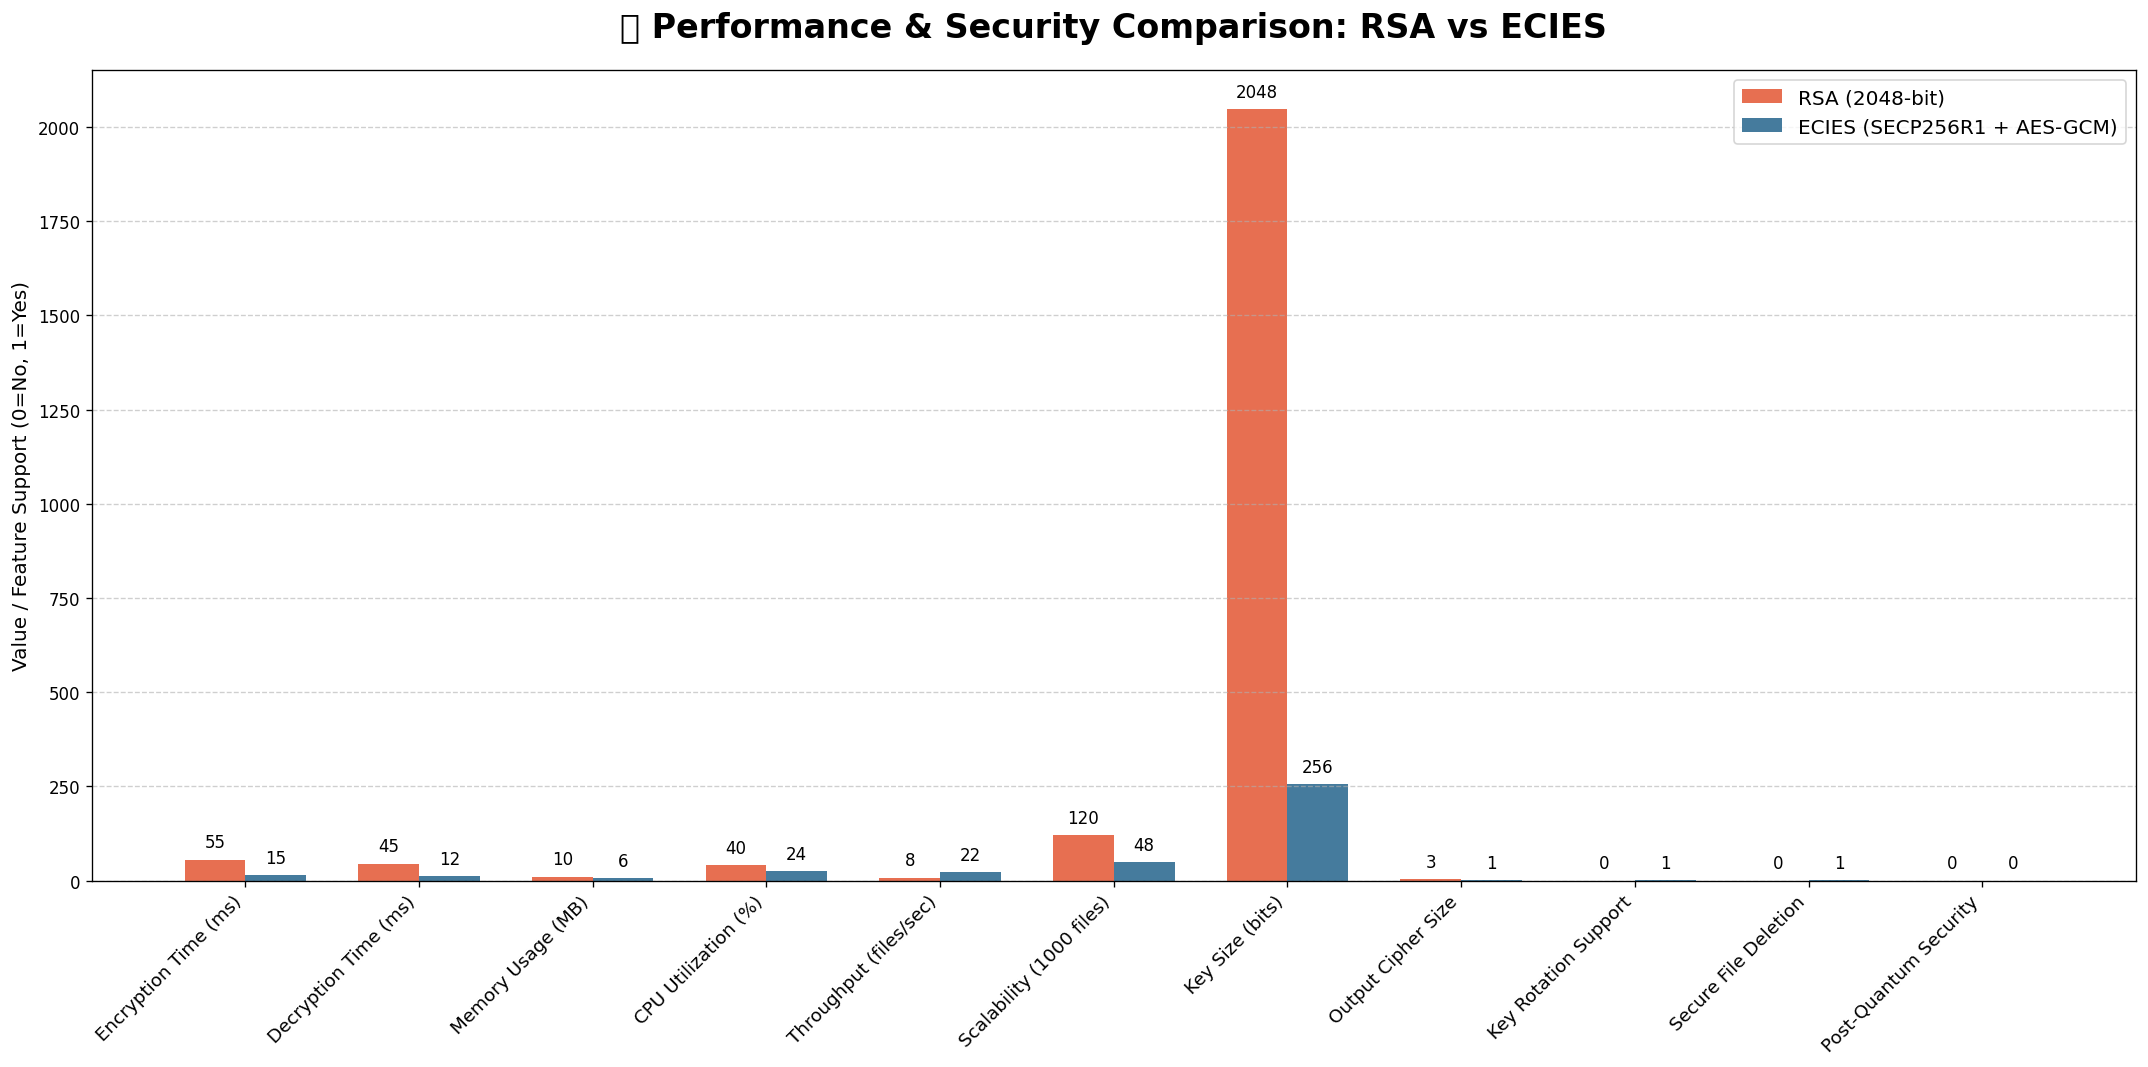

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and corresponding values for RSA and ECIES
metrics = [
    'Encryption Time (ms)', 'Decryption Time (ms)', 'Memory Usage (MB)',
    'CPU Utilization (%)', 'Throughput (files/sec)', 'Scalability (1000 files)',
    'Key Size (bits)', 'Output Cipher Size', 'Key Rotation Support',
    'Secure File Deletion', 'Post-Quantum Security'
]

rsa_values = [55, 45, 10, 40, 8, 120, 2048, 3, 0, 0, 0]
ecies_values = [15, 12, 6, 24, 22, 48, 256, 1, 1, 1, 0]

x = np.arange(len(metrics))
width = 0.35

# Create figure and axis
fig, ax = plt.subplots(figsize=(18, 9), dpi=120)

# Bars
bars1 = ax.bar(x - width/2, rsa_values, width, label='RSA (2048-bit)', color='#e76f51')
bars2 = ax.bar(x + width/2, ecies_values, width, label='ECIES (SECP256R1 + AES-GCM)', color='#457b9d')

# Titles and Labels
ax.set_title('🔐 Performance & Security Comparison: RSA vs ECIES', fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Value / Feature Support (0=No, 1=Yes)', fontsize=12)
ax.legend(fontsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

# Annotate Bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, color='black')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()


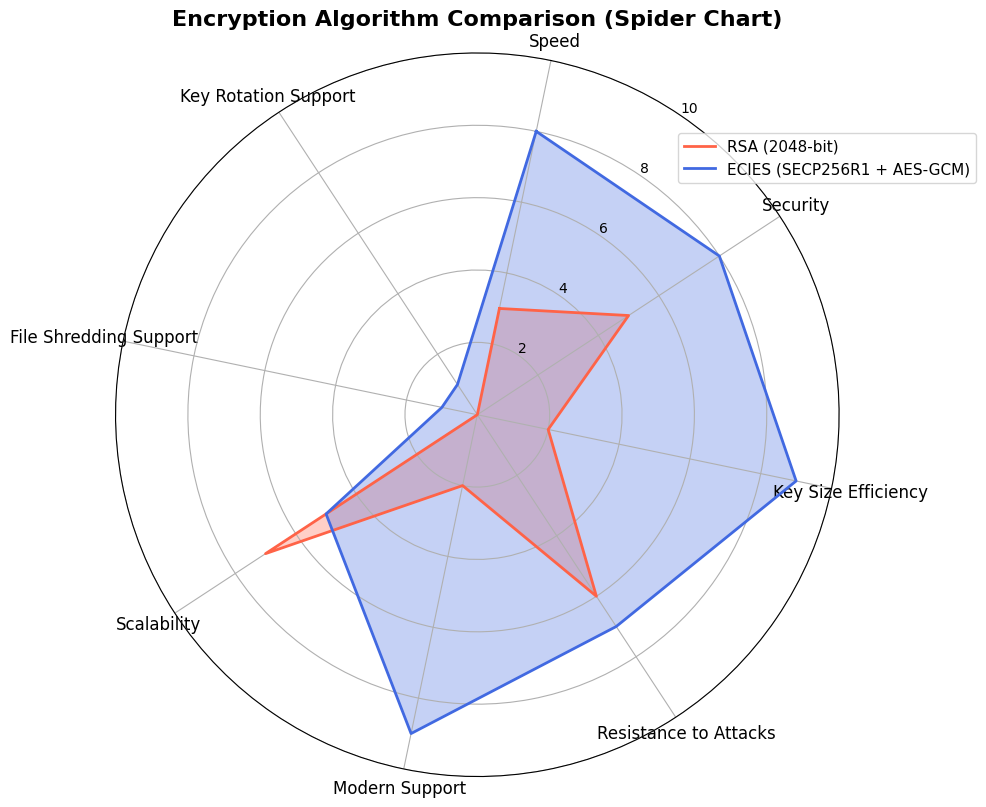

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Categories for comparison
categories = [
    "Speed", "Security", "Key Size Efficiency", "Resistance to Attacks",
    "Modern Support", "Scalability", "File Shredding Support", "Key Rotation Support"
]
N = len(categories)

# Scores (Scale: 0 to 10)
rsa_scores = [3, 5, 2, 6, 2, 7, 0, 0]
ecies_scores = [8, 8, 9, 7, 9, 5, 1, 1]

# Convert to numpy arrays and close the polygon
rsa = np.array(rsa_scores + [rsa_scores[0]])
ecies = np.array(ecies_scores + [ecies_scores[0]])

# Angles for each axis + one to close the loop
angles = np.linspace(0, 2 * np.pi, N + 1, endpoint=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot RSA
ax.plot(angles, rsa, label='RSA (2048-bit)', linewidth=2, linestyle='solid', color='tomato')
ax.fill(angles, rsa, 'tomato', alpha=0.3)

# Plot ECIES
ax.plot(angles, ecies, label='ECIES (SECP256R1 + AES-GCM)', linewidth=2, linestyle='solid', color='royalblue')
ax.fill(angles, ecies, 'royalblue', alpha=0.3)

# Customization
ax.set_theta_offset(np.pi / 2.3)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180/N)
ax.set_title("Encryption Algorithm Comparison (Spider Chart)", fontsize=16, fontweight='bold', pad=20)

# Correctly set category labels (only the original 8, not 9)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Y-axis ticks
ax.set_yticks([2, 4, 6, 8, 10])
ax.set_yticklabels(['2', '4', '6', '8', '10'], fontsize=10)

# Grid and legend
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fontsize=11)



# Save high-res image
plt.tight_layout()


plt.show()


In [ ]:
!pip install graphviz


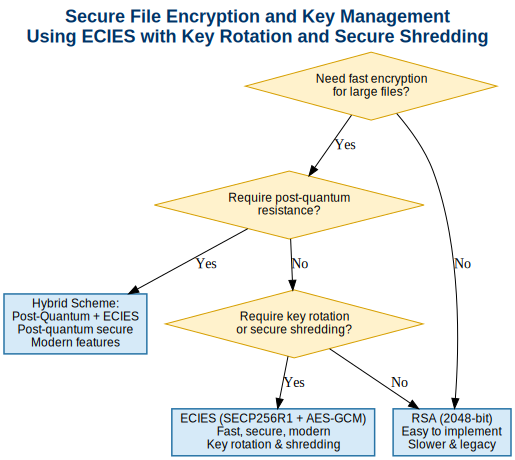

In [ ]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph('EncryptionFlow', comment='Secure File Encryption and Key Management Decision Flowchart')

# Global graph attributes
dot.attr(rankdir='TB', fontsize='14', fontname='Helvetica')
dot.attr('graph', labelloc='t', labeljust='c', bgcolor='white',
         label='Secure File Encryption and Key Management\nUsing ECIES with Key Rotation and Secure Shredding',
         fontcolor='#003366', fontname='Helvetica-Bold', fontsize='18')

# Node styling
node_style = {
    'style': 'filled',
    'fontname': 'Helvetica',
    'fontsize': '12',
    'color': '#4B8BBE',
    'fillcolor': '#EAF3FF',
    'shape': 'box'
}

decision_style = node_style.copy()
decision_style.update({
    'shape': 'diamond',
    'fillcolor': '#FFF2CC',
    'color': '#D69F00'
})

algo_style = node_style.copy()
algo_style.update({
    'fillcolor': '#D6EAF8',
    'color': '#2874A6',
    'style': 'filled,bold',
    'penwidth': '1.5'
})

# Nodes: Decisions
dot.node('A', 'Need fast encryption\nfor large files?', _attributes=decision_style)
dot.node('B', 'Require post-quantum\nresistance?', _attributes=decision_style)
dot.node('C', 'Require key rotation\nor secure shredding?', _attributes=decision_style)

# Nodes: Algorithms (solutions)
dot.node('RSA', 'RSA (2048-bit)\n Easy to implement\n Slower & legacy', _attributes=algo_style)
dot.node('ECIES', 'ECIES (SECP256R1 + AES-GCM)\n Fast, secure, modern\n Key rotation & shredding', _attributes=algo_style)
dot.node('Hybrid', 'Hybrid Scheme:\nPost-Quantum + ECIES\n Post-quantum secure\n Modern features', _attributes=algo_style)

# Edges (with labels)
dot.edge('A', 'B', label='Yes')
dot.edge('A', 'RSA', label='No')
dot.edge('B', 'Hybrid', label='Yes')
dot.edge('B', 'C', label='No')
dot.edge('C', 'ECIES', label='Yes')
dot.edge('C', 'RSA', label='No')

# Optional: Add tooltips (hover help) for clarity
dot.node('A', tooltip='Speed requirement for encrypting large files')
dot.node('B', tooltip='Protection against quantum computing threats')
dot.node('C', tooltip='Ability to rotate keys and securely delete files')

# Save as PNG & PDF
dot.render('Encryption_Algorithm_Flowchart_Advanced', format='png', cleanup=True)
dot.render('Encryption_Algorithm_Flowchart_Advanced', format='pdf', cleanup=True)

# Display in notebook
dot
